# ResNet VS Plain

- ResNet 34 vs Plain 34
- ResNet 50 vs Plain 50

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

성능 평가를 위해 어려운(?) Cat vs Dog 데이터를 불러왔다.

In [2]:
train_dataset, test_dataset = tfds.load(
    name='cats_vs_dogs',
    split=('train[:80%]', 'train[80%:]'),
    as_supervised=True
)
train_len = len(train_dataset)
test_len = len(test_dataset)

tf.Tensor(1, shape=(), dtype=int64)


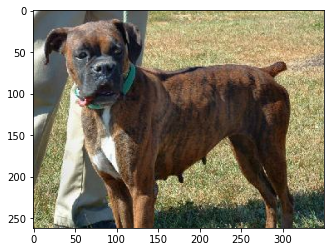

In [3]:
for image, label in train_dataset:
    print(label)
    plt.imshow(image)
    break

[논문](https://arxiv.org/pdf/1512.03385.pdf)과 가장 비슷한 구현을 위해 이미지 size를 32 by 32로 리사이즈 하였다.

In [4]:
def preprocess(image, label):
    _img = tf.cast(image, tf.float32)
    _img = tf.divide(_img, 255)
    _img = tf.image.resize(_img, (32, 32))
    return _img, label

In [5]:
BATCH_SIZE = 128
train_databatch = train_dataset.map(preprocess).batch(BATCH_SIZE).repeat()
test_databatch = test_dataset.map(preprocess).batch(BATCH_SIZE).repeat()

Identity Block은 shortcut의 channel을 변경해주지 않고 단순히 Add만을 수행해주는 블럭이다. <br/>
ResNet50 모델 생성을 위한 `is_50` 잔차학습을 하지 않은 보통 모델 생성을 위한 `plain` 파라미터를 받는다.

In [6]:
def identity_block(x, filter, is_50=False, plain=False):
    x_skip = x
    if not is_50:
        x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    else:
        x = tf.keras.layers.Conv2D(filter, (1,1), padding = 'valid')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    
    if is_50:
        x_skip = tf.keras.layers.Conv2D(filter*4, (1,1), padding='valid')(x_skip)
        x = tf.keras.layers.BatchNormalization(axis=3)(x_skip)
    if not plain:
        x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

Convolution Block은 shortcut의 Channel을 적절히 변경해줘야 한다.

In [7]:
def convolutional_block(x, filter, is_50=False, plain=False):
    x_skip = x
    if not is_50:
        x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    else:
        x = tf.keras.layers.Conv2D(filter, (1,1), padding = 'valid', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (1,1))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    if is_50:
        x = tf.keras.layers.Activation('relu')(x)
        
        x = tf.keras.layers.Conv2D(filter * 4, (1,1), padding='valid', strides = (1,1))(x)
    if not is_50:
        x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    else:
        x_skip = tf.keras.layers.Conv2D(filter * 4, (1,1), padding='valid', strides = (2,2))(x_skip)
    x_skip = tf.keras.layers.BatchNormalization(axis=3)(x_skip)
    if not plain:
        x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [8]:
def build_resnet(input_shape=(32, 32, 3), classes = 10, is_50=False, plain=False):
    x_input = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x_input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    block_layers = [3, 4, 6, 3]
    filter_size = 64
    for i in range(4):
        if i == 0:
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size, is_50, plain)
        else:
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size, is_50)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size, is_50, plain)
    
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model

In [9]:
resnet_34 = build_resnet(input_shape=(32,32,3), is_50=False)
resnet_34.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
resnet_34.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           batch_normalization[0][0]        
___________________________________________________________________________________________

In [10]:
plain_34 = build_resnet(input_shape=(32,32,3), is_50=False, plain=True)
plain_34.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
plain_34.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 16, 16, 64)   256         conv2d_36[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16, 16, 64)   0           batch_normalization_36[0][0]     
___________________________________________________________________________________________

In [11]:
EPOCHS = 30

In [12]:
resnet_34_history = resnet_34.fit(
    train_databatch,
    steps_per_epoch=train_len/BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=test_databatch,
    validation_steps=test_len/BATCH_SIZE
)

Epoch 1/30
145/145 [==============================] - 29s 160ms/step - loss: 0.7647 - accuracy: 0.6167 - val_loss: 0.6932 - val_accuracy: 0.5133
Epoch 2/30
145/145 [==============================] - 22s 153ms/step - loss: 0.5836 - accuracy: 0.6979 - val_loss: 0.6692 - val_accuracy: 0.5961
Epoch 3/30
145/145 [==============================] - 22s 152ms/step - loss: 0.5325 - accuracy: 0.7326 - val_loss: 1.1979 - val_accuracy: 0.4961
Epoch 4/30
145/145 [==============================] - 22s 153ms/step - loss: 0.4606 - accuracy: 0.7789 - val_loss: 1.4178 - val_accuracy: 0.5159
Epoch 5/30
145/145 [==============================] - 22s 152ms/step - loss: 0.4141 - accuracy: 0.8069 - val_loss: 1.3324 - val_accuracy: 0.5202
Epoch 6/30
145/145 [==============================] - 22s 154ms/step - loss: 0.3700 - accuracy: 0.8323 - val_loss: 0.7783 - val_accuracy: 0.6696
Epoch 7/30
145/145 [==============================] - 23s 155ms/step - loss: 0.3453 - accuracy: 0.8441 - val_loss: 1.2259 - val_ac

In [13]:
plain_34_history = plain_34.fit(
    train_databatch,
    steps_per_epoch=train_len/BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=test_databatch,
    validation_steps=test_len/BATCH_SIZE
)

Epoch 1/30
145/145 [==============================] - 27s 159ms/step - loss: 0.7212 - accuracy: 0.5631 - val_loss: 0.7125 - val_accuracy: 0.5099
Epoch 2/30
145/145 [==============================] - 22s 153ms/step - loss: 0.6282 - accuracy: 0.6622 - val_loss: 0.6683 - val_accuracy: 0.5916
Epoch 3/30
145/145 [==============================] - 22s 152ms/step - loss: 0.5682 - accuracy: 0.7032 - val_loss: 0.6045 - val_accuracy: 0.6724
Epoch 4/30
145/145 [==============================] - 22s 152ms/step - loss: 0.5234 - accuracy: 0.7366 - val_loss: 0.9329 - val_accuracy: 0.6713
Epoch 5/30
145/145 [==============================] - 22s 150ms/step - loss: 0.4851 - accuracy: 0.7637 - val_loss: 0.6827 - val_accuracy: 0.7072
Epoch 6/30
145/145 [==============================] - 22s 150ms/step - loss: 0.4563 - accuracy: 0.7800 - val_loss: 0.7593 - val_accuracy: 0.7081
Epoch 7/30
145/145 [==============================] - 22s 152ms/step - loss: 0.4303 - accuracy: 0.7990 - val_loss: 0.7908 - val_ac

In [14]:
resnet_50 = build_resnet(input_shape=(32,32,3), is_50=True)
resnet_50.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
resnet_50.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_72 (Conv2D)              (None, 16, 16, 64)   9472        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_72 (BatchNo (None, 16, 16, 64)   256         conv2d_72[0][0]                  
__________________________________________________________________________________________________
activation_66 (Activation)      (None, 16, 16, 64)   0           batch_normalization_72[0][0]     
___________________________________________________________________________________________

In [15]:
plain_50 = build_resnet(input_shape=(32,32,3), is_50=True, plain=True)
plain_50.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
plain_50.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_124 (Conv2D)             (None, 16, 16, 64)   9472        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_121 (BatchN (None, 16, 16, 64)   256         conv2d_124[0][0]                 
__________________________________________________________________________________________________
activation_102 (Activation)     (None, 16, 16, 64)   0           batch_normalization_121[0][0]    
___________________________________________________________________________________________

In [16]:
resnet_50_history = resnet_50.fit(
    train_databatch,
    steps_per_epoch=train_len/BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=test_databatch,
    validation_steps=test_len/BATCH_SIZE
)

Epoch 1/30
145/145 [==============================] - 27s 160ms/step - loss: 1.0089 - accuracy: 0.5426 - val_loss: 0.7160 - val_accuracy: 0.4908
Epoch 2/30
145/145 [==============================] - 22s 152ms/step - loss: 0.6227 - accuracy: 0.6549 - val_loss: 0.7558 - val_accuracy: 0.4903
Epoch 3/30
145/145 [==============================] - 22s 152ms/step - loss: 0.5629 - accuracy: 0.7104 - val_loss: 0.6299 - val_accuracy: 0.6617
Epoch 4/30
145/145 [==============================] - 25s 169ms/step - loss: 0.5103 - accuracy: 0.7473 - val_loss: 0.6440 - val_accuracy: 0.6466
Epoch 5/30
145/145 [==============================] - 22s 153ms/step - loss: 0.4708 - accuracy: 0.7739 - val_loss: 0.9315 - val_accuracy: 0.5669
Epoch 6/30
145/145 [==============================] - 22s 153ms/step - loss: 0.4392 - accuracy: 0.7938 - val_loss: 0.7792 - val_accuracy: 0.6073
Epoch 7/30
145/145 [==============================] - 23s 156ms/step - loss: 0.4101 - accuracy: 0.8085 - val_loss: 0.7592 - val_ac

In [17]:
plain_50_history = plain_50.fit(
    train_databatch,
    steps_per_epoch=train_len/BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=test_databatch,
    validation_steps=test_len/BATCH_SIZE
)

Epoch 1/30
145/145 [==============================] - 26s 158ms/step - loss: 0.8326 - accuracy: 0.5407 - val_loss: 0.6962 - val_accuracy: 0.4953
Epoch 2/30
145/145 [==============================] - 22s 151ms/step - loss: 0.6510 - accuracy: 0.6456 - val_loss: 1.1984 - val_accuracy: 0.4925
Epoch 3/30
145/145 [==============================] - 22s 151ms/step - loss: 0.5911 - accuracy: 0.6956 - val_loss: 1.4755 - val_accuracy: 0.5361
Epoch 4/30
145/145 [==============================] - 22s 152ms/step - loss: 0.5287 - accuracy: 0.7378 - val_loss: 0.5902 - val_accuracy: 0.7130
Epoch 5/30
145/145 [==============================] - 22s 153ms/step - loss: 0.4939 - accuracy: 0.7625 - val_loss: 0.7739 - val_accuracy: 0.6685
Epoch 6/30
145/145 [==============================] - 22s 153ms/step - loss: 0.4488 - accuracy: 0.7901 - val_loss: 0.6049 - val_accuracy: 0.6958
Epoch 7/30
145/145 [==============================] - 22s 154ms/step - loss: 0.4244 - accuracy: 0.8055 - val_loss: 0.6210 - val_ac

In [18]:
def plot_twin_resnet_plain(resnet_history, plain_history, name):
    plt.figure(figsize=(15, 5))
    plt.subplot(1,2,1)
    plt.plot(resnet_history.history['val_accuracy'], label='resnet', color='r')
    plt.plot(plain_history.history['val_accuracy'], label='plain', color='g')
    plt.title("val accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(resnet_history.history['val_loss'], label='resnet', color='r')
    plt.plot(plain_history.history['val_loss'], label='plain', color='g')
    plt.title("val loss")
    plt.legend()
    plt.suptitle(name)
    plt.show()

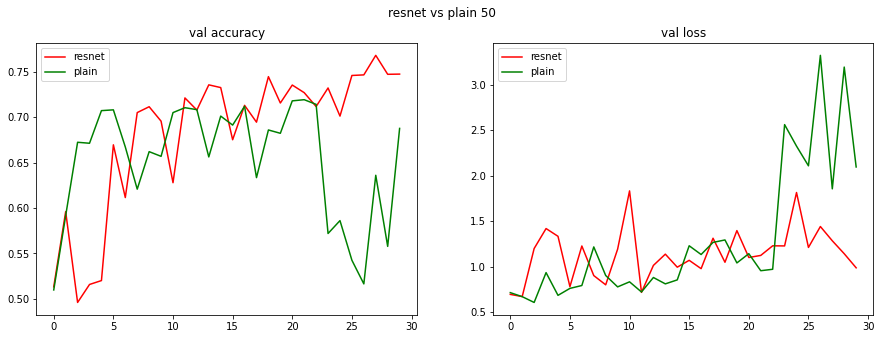

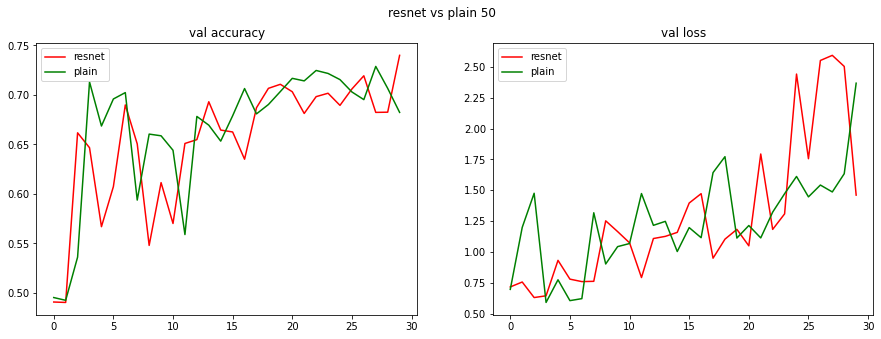

In [19]:
plot_twin_resnet_plain(resnet_34_history, plain_34_history, name='resnet vs plain 50')
plot_twin_resnet_plain(resnet_50_history, plain_50_history, name='resnet vs plain 50')

## 결론

ResNet이 나온 이후로 Resual Block이라는 개념은 Classification 뿐만 아니라 정말 다양한 분야에서 사용되어 왔다. 하지만 직관적인 이해만 있을 뿐 실제로 성능적인 장점을 확인해보지는 못했었는데 이번 기회로 잔차학습의 강점에 대해 알게되었다.

위 실험에서 4가지 모델을 Cat_vs_Dogs 데이터를 이용해 학습시켰는데 결과를 정리해보았다.

|  layer  | Resnet | Plain |
| --- | ---    | ---   |
| 34 | 74.74% | 71.93% |
| 50 | 73.99% | 72.87% |